In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys

In [2]:
from utils_custom import *

### TF Regulation activity and expression plots

In [3]:
# Define file paths 
data_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/dynamic.h5'
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output'
tf_pairs_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/combinatorial_control/SLIDE_LF_enriched_pair_GC-1_PB-2.csv'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(data_file)

#### Windows

In [6]:
# Assign window indices for each branch between 0 to 60
pb_window_indices = list(range(30, 46)) + [2]
abc_window_indices = [1] + list(range(4, 30)) + [0]
gc_window_indices = list(range(46, 61)) + [3]

In [7]:
# Create a custom blue-white-green colormap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap
colors_list = ['red', 'white', 'blue']
n_bins = 256  # Number of color gradations
custom_cmap = LinearSegmentedColormap.from_list('custom', colors_list, N=n_bins)

In [13]:
positive_control_regulations_pb = [('PRDM1', 'BATF'), ('PRDM1', 'IRF4'), ('XBP1','PRDM1'), ('PRDM1','IRF8')]
positive_control_regulations_gc = [('PRDM1', 'BATF'), ('IRF8','BATF'), ('XBP1','PRDM1'), ('PRDM1','IRF8')]

In [14]:
import matplotlib
from typing import Tuple, Optional, Union

def fig_regulation_heatmap(network:dictys.net.dynamic_network,start:int,stop:int,regulations:list[Tuple[str,str]],num:int=100,dist:float=1.5,ax:Optional[matplotlib.axes.Axes]=None,cmap:Union[str,matplotlib.cm.ScalarMappable]='coolwarm',figsize:Tuple[float,float]=(2,0.22),vmax:Optional[float]=None)->Tuple[matplotlib.pyplot.Figure,matplotlib.axes.Axes,matplotlib.cm.ScalarMappable]:
	"""Draws pseudo-time dependent heatmap of individual regulation strengths.
	
	Parameters
	----------
	network:
		Dynamic network object
	start:
		Branch starting node ID 
	stop:
		Branch ending node ID 
	regulations:
		List of regulations in (Regulator name, target name) format to draw strength
	num:
		Number of points from starting to ending nodes to draw
	dist:
		Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
	ax:
		Axes to draw on.
	figsize:
		Figure size for each regulation as a row. Should remain unassigned when ax is assigned.
	cmap:
		Colormap in matplotlib string or matplotlib.cm.ScalarMappable
	vmax:
		Maximum value in colormap. Should remain unassigned when cmap is a matplotlib.cm.ScalarMappable instance.
	
	Returns
	-------
	fig:
		Heatmap figure
	ax:
		Heatmap axes
	cmap:
		Heatmap colormap
	"""
	import numpy as np
	import matplotlib.pyplot as plt
	from dictys.net import stat
	#Get dynamic network edge strength
	pts,fsmooth=network.linspace(start,stop,num,dist)
	stat1_net=fsmooth(stat.net(network))
	#Get pseudotime
	stat1_x=stat.pseudotime(network,pts)
	dx=pd.Series(stat1_x.compute(pts)[0])
	#Test regulation existence
	tdict=[dict(zip(x,range(len(x)))) for x in stat1_net.names]
	t1=[[x[y] for x in regulations if x[y] not in tdict[y]] for y in range(2)]
	if len(t1[0])>0:
		raise ValueError('Regulator gene(s) {} not found in network.'.format('/'.join(t1[0])))
	if len(t1[1])>0:
		raise ValueError('Target gene(s) {} not found in network.'.format('/'.join(t1[1])))
	#Extract regulations to draw
	dnet=stat1_net.compute(pts)
	t1=np.array([[tdict[0][x[0]],tdict[1][x[1]]] for x in regulations]).T
	dnet=dnet[t1[0],t1[1]]
	#Create figure and axes
	if ax is None:
		figsize=(figsize[0],figsize[1]*dnet.shape[0])
		fig=plt.figure(figsize=figsize)
		ax=fig.add_subplot(111)
	else:
		if figsize is not None:
			raise ValueError('figsize should not be set if ax is set.')
		fig=ax.get_figure()
		figsize=fig.get_size_inches()
	aspect=(figsize[1]/dnet.shape[0])/(figsize[0]/dnet.shape[1])
	#Determine colormap
	if isinstance(cmap,str):
		if vmax is None:
			vmax=np.quantile(np.abs(dnet).ravel(),0.95)
		cmap=matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-vmax,vmax=vmax),cmap=cmap)		# pylint: disable=E1130
	elif vmax is not None:
		raise ValueError('vmax should not be set if cmap is a matplotlib.cm.ScalarMappable.')
	if hasattr(cmap, 'to_rgba'):
		# Original behavior for dictys default matplotlib colormaps
		ax.imshow(cmap.to_rgba(dnet), aspect=aspect, interpolation='none')
	else:
		# New behavior for customcolormaps
		im = ax.imshow(dnet, aspect=aspect, interpolation='none', cmap=cmap)
		plt.colorbar(im, label='Regulation strength')  # Add colorbar for custom colormaps
	#set pseudotime labels
	ax.set_xlabel('Pseudotime')
	num_ticks = 10
	tick_positions = np.linspace(0, dnet.shape[1]-1, num_ticks, dtype=int)
	tick_labels = dx.iloc[tick_positions]
	#print('dx values: ', tick_labels)
	ax.set_xticks(tick_positions)
	ax.set_xticklabels([f"{x:.6f}" for x in tick_labels], rotation=45, ha='right')
	ax.set_yticks(list(range(len(regulations))))
	ax.set_yticklabels(['-'.join(x) for x in regulations])
	return fig,ax,cmap

dx values:  0      0.000000
22     0.000395
44     0.000789
66     0.001184
88     0.001578
110    0.001973
132    0.002368
154    0.002762
176    0.003157
199    0.003570
dtype: float64


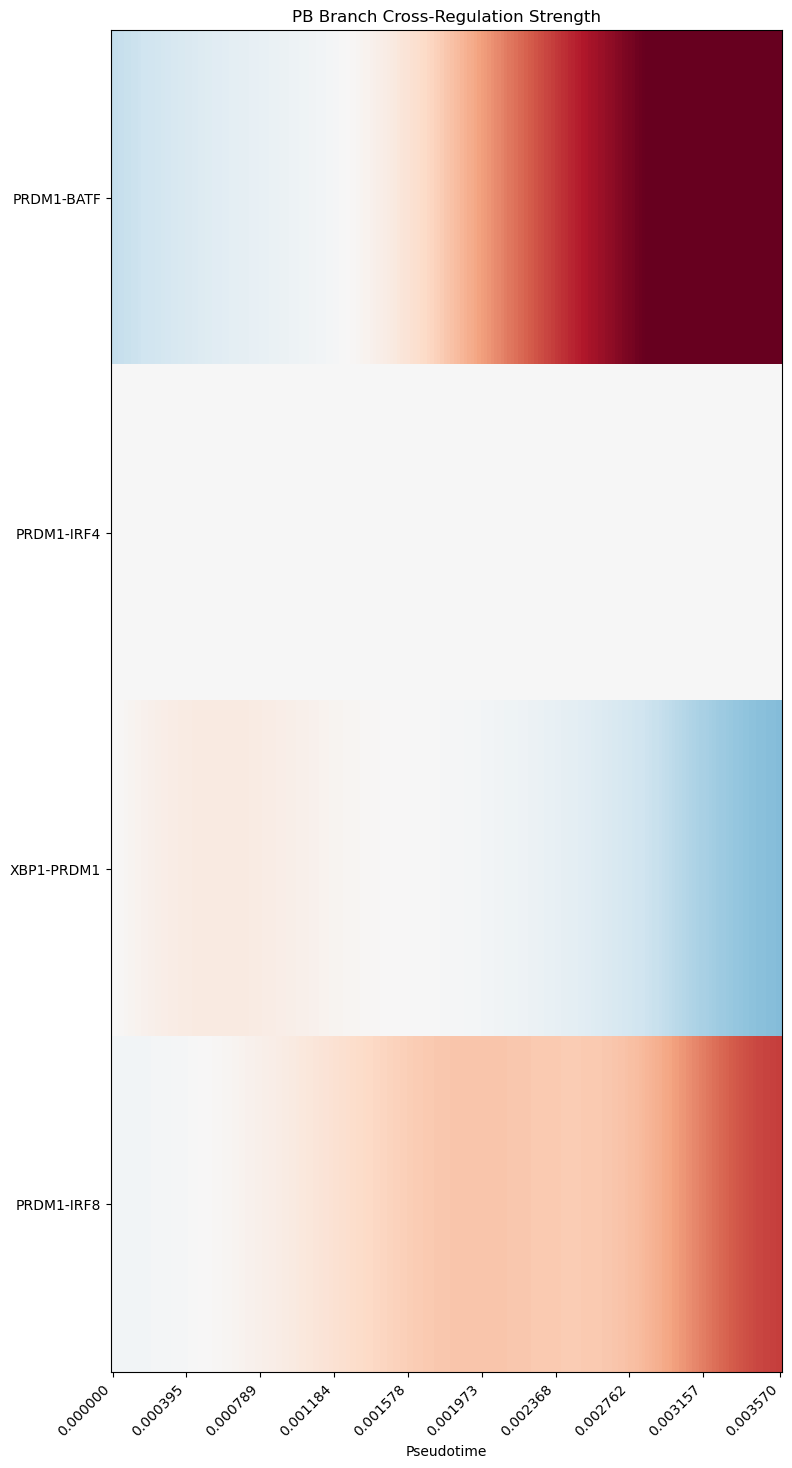

In [15]:
# Plot for PB branch (including ACtB cells)
fig_pb, ax_pb, cmap_pb = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=1,  # First window index for PB branch
    stop=2,  # Last window index for PB branch
    regulations=positive_control_regulations_pb,
    num=200,  # Number of points to interpolate
    dist=0.0005,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    figsize=(8, 4),  # Adjust figure size as needed
    cmap='RdBu'
)
plt.title('PB Branch Cross-Regulation Strength')
plt.tight_layout()
plt.show()

dx values:  0      0.000000
22     0.000459
44     0.000919
66     0.001378
88     0.001837
110    0.002297
132    0.002756
154    0.003215
176    0.003675
199    0.004155
dtype: float64


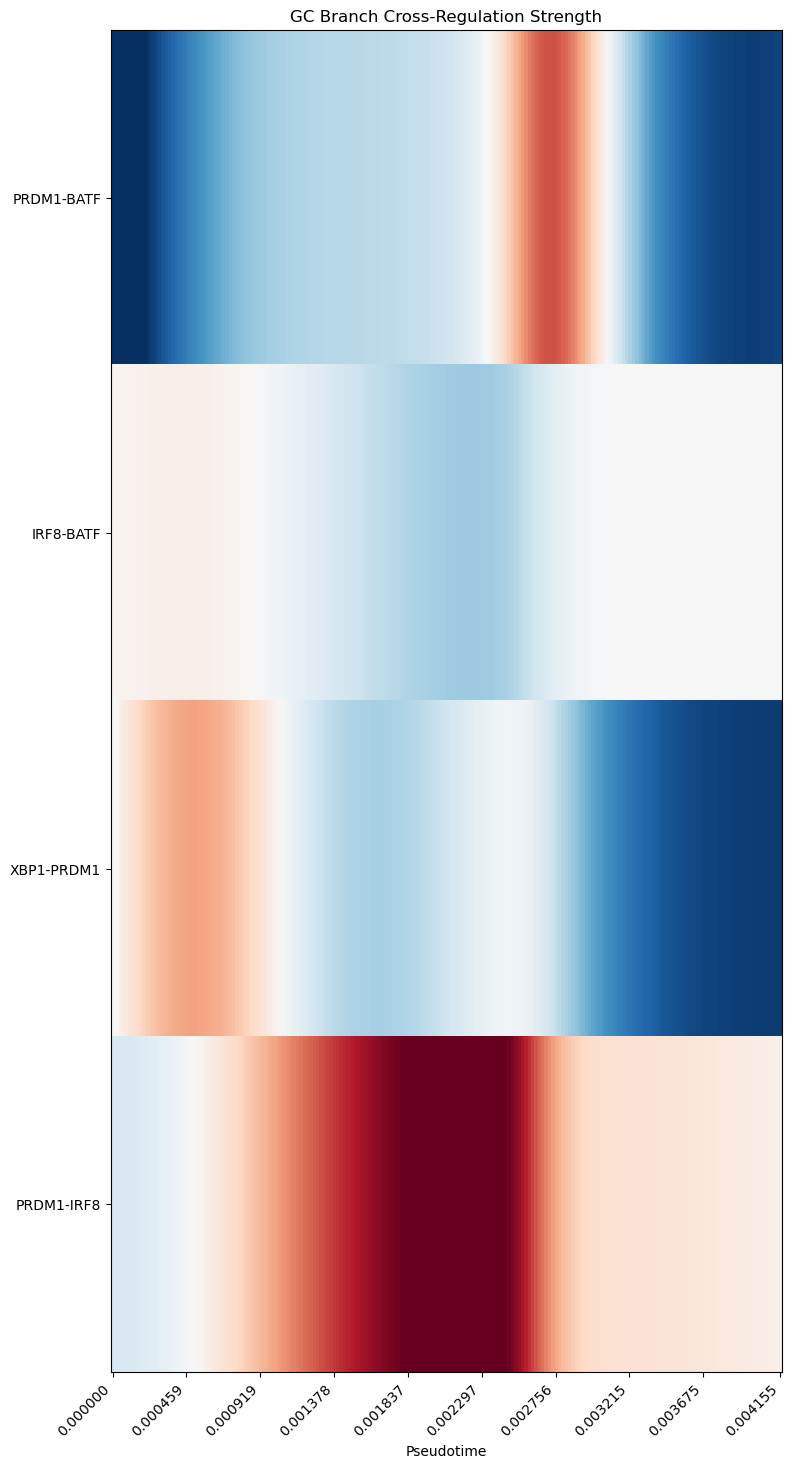

In [20]:
# Plot for PB branch (including ACtB cells)
fig_gc, ax_gc, cmap_gc = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=1,  # First window index for PB branch
    stop=3,  # Last window index for PB branch
    regulations=positive_control_regulations_gc,
    num=200,  # Number of points to interpolate
    dist=0.0005,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    figsize=(8, 4),  # Adjust figure size as needed
    cmap='RdBu'
)
plt.title('GC Branch Cross-Regulation Strength')
plt.tight_layout()
plt.show()

#### Expression

In [16]:
def compute_chars(self,start:int,stop:int,num:int=100,dist:float=1.5,mode:str='regulation',sparsity:float=0.01)->pd.DataFrame:
		"""
		Compute curve characteristics for one branch.

		Parameters
		----------
		start:
			Branch starting node ID 
		stop:
			Branch ending node ID 
		num:
			Number of points from starting to ending nodes to draw
		dist:
			Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
		mode:
			Mode or measure to compute characteristics. Accepts:

			* 'regulation': based on target count

			* 'expression': based on CPM

		sparsity:
			The number of edges to regard as positive when binarizing network. Only relevant when mode=='regulation'

		Returns
		-------
		List of returns from dictys.plot.dynamic.draw_dynamic1 for each of the patterns drawn
		"""
		from dictys.net import stat
		from dictys.plot.dynamic import _compute_chars_
		pts,fsmooth=self.linspace(start,stop,num,dist)
		if mode=='regulation':
			#Log number of targets
			stat1_net=fsmooth(stat.net(self))
			stat1_netbin=stat.fbinarize(stat1_net,sparsity=sparsity)
			stat1_y=stat.flnneighbor(stat1_netbin)
		elif mode=='expression':
			stat1_y=fsmooth(stat.lcpm(self,cut=0))
		else:
			raise ValueError(f'Unknown mode {mode}.')
		#Pseudo time
		stat1_x=stat.pseudotime(self,pts)
		dy=pd.DataFrame(stat1_y.compute(pts),index=stat1_y.names[0])
		dx=pd.Series(stat1_x.compute(pts)[0])
		return dy,dx


#### PB

In [31]:
# Call compute_chars for expression mode
dy, dx = compute_chars(dictys_dynamic_object,
    start=1,          # Starting node ID
    stop=2,           # Ending node ID
    num=200,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance
    mode='expression' # Use expression (CPM) mode
)

# Print basic info about the returns
print("DataFrame dy (gene expression):")
print(f"Shape: {dy.shape}")
print(f"First few genes: {list(dy.index[:5])}\n")
# Optional: display first few rows and columns of expression data
print("\nExpression values (first 5 genes x 5 timepoints):")
print(dy.iloc[:5, :5])
print("Series dx (pseudotime):")
print(f"Length: {len(dx)}")
print(f"First few timepoints: {list(dx[:5])}")

DataFrame dy (gene expression):
Shape: (13169, 200)
First few genes: ['A1BG', 'A1BG-AS1', 'A2M', 'A2ML1-AS1', 'A4GALT']


Expression values (first 5 genes x 5 timepoints):
                  0         1         2         3         4
A1BG       4.093047  4.097212  4.101484  4.105864  4.110352
A1BG-AS1   3.608677  3.609348  3.610043  3.610762  3.611508
A2M        0.676160  0.668292  0.660423  0.652563  0.644723
A2ML1-AS1  1.457429  1.457392  1.457367  1.457354  1.457355
A4GALT     2.127432  2.121225  2.115045  2.108904  2.102813
Series dx (pseudotime):
Length: 200
First few timepoints: [0.0, 1.7937276396149753e-05, 3.587455279229951e-05, 5.381182918844926e-05, 7.174910558459901e-05]


In [22]:
# Calculate gradients for all genes
gradients_df = pd.DataFrame(
    np.vstack([np.gradient(dy.loc[gene].values, dx.values) for gene in dy.index]),
    columns=dy.columns,
    index=dy.index
)

# Display the shape and first few rows
print("Gradients DataFrame shape:", gradients_df.shape)
print("\nFirst few genes and timepoints:")
print(gradients_df.iloc[:5, :5])

Gradients DataFrame shape: (13169, 200)

First few genes and timepoints:
                    0           1           2           3           4
A1BG       232.228463  235.195648  241.160012  247.182264  253.258163
A1BG-AS1    37.392869   38.060196   39.421133   40.835305   42.304027
A2M       -438.642015 -438.672314 -438.444245 -437.628677 -436.205924
A2ML1-AS1   -2.037650   -1.719589   -1.056723   -0.339294    0.434825
A4GALT    -346.058718 -345.297555 -343.455328 -340.962772 -337.799624


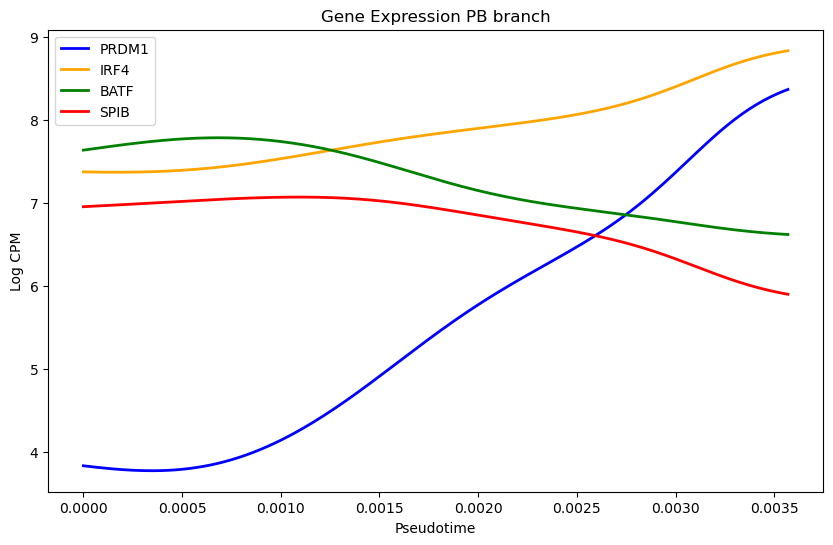

In [59]:
# Plot expression trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PRDM1', 'IRF4','BATF','SPIB']
colors = ['blue', 'orange', 'green','red','purple','gray']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy.index:
        plt.plot(dx, dy.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('Gene Expression PB branch')
plt.legend()
plt.show()

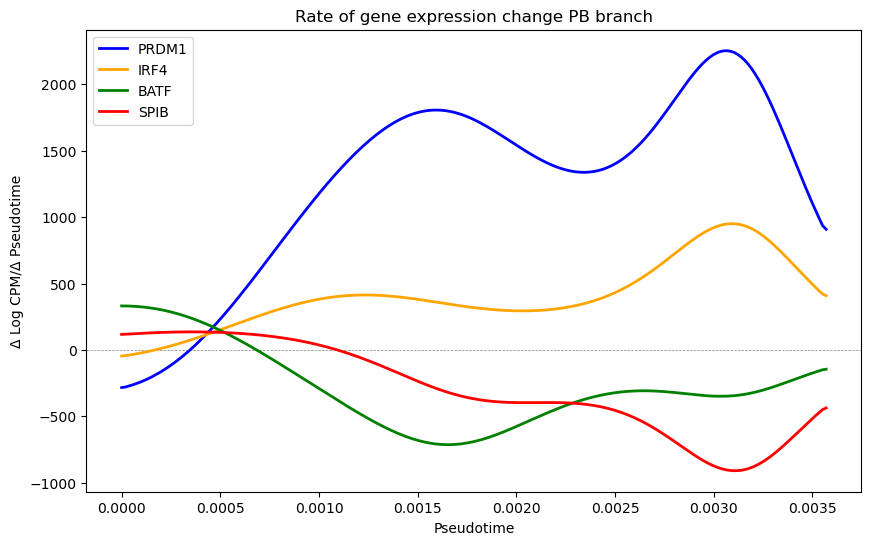

In [25]:
plt.figure(figsize=(10, 6))

# Add horizontal line at y=0 first (so it's behind the data)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot gene trajectories
genes_of_interest = ['PRDM1', 'IRF4', 'BATF', 'SPIB']
colors = ['blue', 'orange', 'green', 'red']

for gene, color in zip(genes_of_interest, colors):
    if gene in gradients_df.index:
        plt.plot(dx, gradients_df.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Δ Log CPM/Δ Pseudotime')
plt.title('Rate of gene expression change PB branch')
plt.legend()
plt.show()

In [42]:
# Call compute_chars for regulation mode
dy_tf, dx_tf = compute_chars(dictys_dynamic_object,
    start=1,          # Starting node ID
    stop=2,           # Ending node ID
    num=200,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance (equispaced sampling with this distance)
    mode='regulation' # Use log(target count) for TFs
)

# Print basic info about the returns
print("DataFrame dy (target counts):")
print(f"Shape: {dy_tf.shape}")
print(f"First few genes: {list(dy_tf.index[:5])}\n")
# Optional: display first few rows and columns of expression data
print("\nTarget counts (first 5 genes x 5 timepoints):")
print(dy_tf.iloc[:5, :5])
print("Series dx (pseudotime):")
print(f"Length: {len(dx_tf)}")
print(f"First few timepoints: {list(dx_tf[:5])}")

DataFrame dy (target counts):
Shape: (245, 200)
First few genes: ['AHR', 'ARNT', 'ASCL2', 'ATF1', 'ATF2']


Target counts (first 5 genes x 5 timepoints):
              0         1         2         3         4
AHR    9.377211  9.353147  9.344296  9.335390  9.350939
ARNT   6.700440  6.700440  6.686501  6.714246  6.714246
ASCL2  3.321928  3.459432  3.459432  3.459432  3.459432
ATF1   5.392317  5.357552  5.426265  5.459432  5.459432
ATF2   6.247928  6.247928  6.209453  6.209453  6.189825
Series dx (pseudotime):
Length: 200
First few timepoints: [0.0, 1.7937276396149753e-05, 3.587455279229951e-05, 5.381182918844926e-05, 7.174910558459901e-05]


In [44]:
# Calculate gradients for all TFs
gradients_df_tf = pd.DataFrame(
    np.vstack([np.gradient(dy_tf.loc[gene].values, dx_tf.values) for gene in dy_tf.index]),
    columns=dy_tf.columns,
    index=dy_tf.index
)

# Display the shape and first few rows
print("Gradients DataFrame shape:", gradients_df_tf.shape)
print("\nFirst few genes and timepoints:")
print(gradients_df_tf.iloc[:5, :5])

Gradients DataFrame shape: (245, 200)

First few genes and timepoints:
                 0            1             2             3           4
AHR   -1341.547310  -917.492203 -4.949601e+02  1.851807e+02  371.789988
ARNT      0.000000  -388.553720  3.848354e+02  7.733892e+02  381.187662
ASCL2  7665.797232  3832.898616 -1.455192e-11 -1.455192e-11    0.000000
ATF1  -1938.165940   946.278888  2.839885e+03  9.245234e+02 -924.523412
ATF2      0.000000 -1072.463482 -1.072463e+03 -5.471513e+02 -547.151260


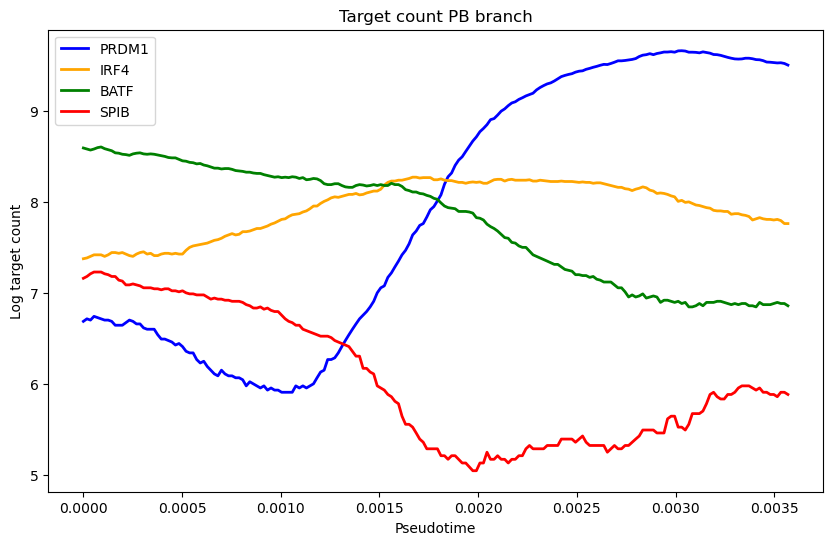

In [43]:
# Plot target count trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PRDM1', 'IRF4','BATF','SPIB']
colors = ['blue', 'orange', 'green','red','purple','gray']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy_tf.index:
        plt.plot(dx_tf, dy_tf.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log target count')
plt.title('Target count PB branch')
plt.legend()
plt.show()

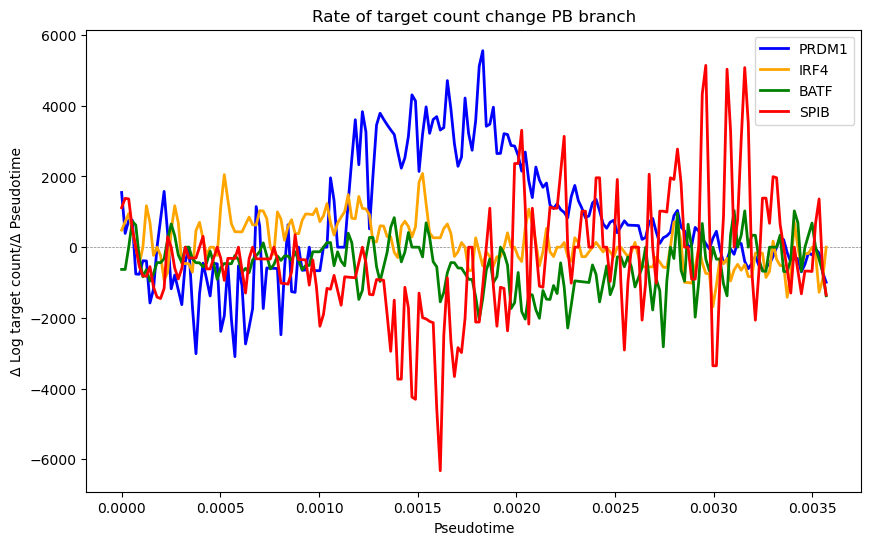

In [45]:
plt.figure(figsize=(10, 6))

# Add horizontal line at y=0 first (so it's behind the data)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot gene trajectories
genes_of_interest = ['PRDM1', 'IRF4', 'BATF', 'SPIB']
colors = ['blue', 'orange', 'green', 'red']

for gene, color in zip(genes_of_interest, colors):
    if gene in gradients_df_tf.index:
        plt.plot(dx_tf, gradients_df_tf.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Δ Log target count/Δ Pseudotime')
plt.title('Rate of target count change PB branch')
plt.legend()
plt.show()

#### GC

In [26]:
# Call compute_chars for expression mode
dy, dx = compute_chars(dictys_dynamic_object,
    start=1,          # Starting node ID
    stop=3,           # Ending node ID
    num=200,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance
    mode='expression' # Use expression (CPM) mode
)

# Print basic info about the returns
print("DataFrame dy (gene expression):")
print(f"Shape: {dy.shape}")
print(f"First few genes: {list(dy.index[:5])}\n")
# Optional: display first few rows and columns of expression data
print("\nExpression values (first 5 genes x 5 timepoints):")
print(dy.iloc[:5, :5])
print("Series dx (pseudotime):")
print(f"Length: {len(dx)}")
print(f"First few timepoints: {list(dx[:5])}")

DataFrame dy (gene expression):
Shape: (13169, 200)
First few genes: ['A1BG', 'A1BG-AS1', 'A2M', 'A2ML1-AS1', 'A4GALT']


Expression values (first 5 genes x 5 timepoints):
                  0         1         2         3         4
A1BG       4.092648  4.097451  4.102391  4.107468  4.112685
A1BG-AS1   3.608616  3.609388  3.610190  3.611025  3.611893
A2M        0.676537  0.667417  0.658301  0.649204  0.640146
A2ML1-AS1  1.457493  1.457455  1.457432  1.457426  1.457439
A4GALT     2.127545  2.120335  2.113166  2.106056  2.099022
Series dx (pseudotime):
Length: 200
First few timepoints: [0.0, 2.087924804899648e-05, 4.175849609799296e-05, 6.263774414698945e-05, 8.351699219598593e-05]


In [27]:
# Calculate gradients for all genes
gradients_df = pd.DataFrame(
    np.vstack([np.gradient(dy.loc[gene].values, dx.values) for gene in dy.index]),
    columns=dy.columns,
    index=dy.index
)

# Display the shape and first few rows
print("Gradients DataFrame shape:", gradients_df.shape)
print("\nFirst few genes and timepoints:")
print(gradients_df.iloc[:5, :5])

Gradients DataFrame shape: (13169, 200)

First few genes and timepoints:
                    0           1           2           3           4
A1BG       230.026734  233.310764  239.898104  246.518601  253.161231
A1BG-AS1    36.962714   37.701713   39.209553   40.777386   42.405728
A2M       -436.800024 -436.710366 -436.135902 -434.756486 -432.544286
A2ML1-AS1   -1.829122   -1.457970   -0.681064    0.166370    1.086900
A4GALT    -345.299444 -344.330729 -341.958059 -338.699629 -334.526570


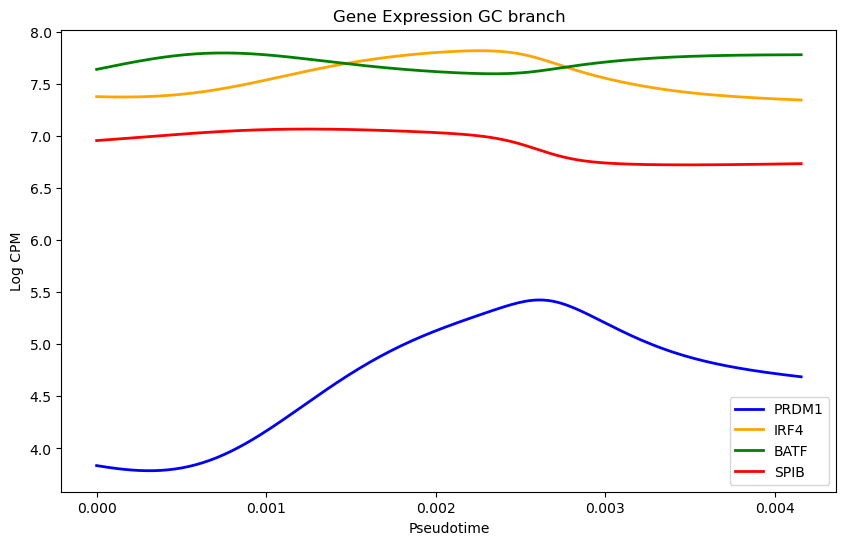

In [28]:
# Plot expression trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PRDM1', 'IRF4','BATF','SPIB']
colors = ['blue', 'orange', 'green','red','purple','gray']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy.index:
        plt.plot(dx, dy.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('Gene Expression GC branch')
plt.legend()
plt.show()

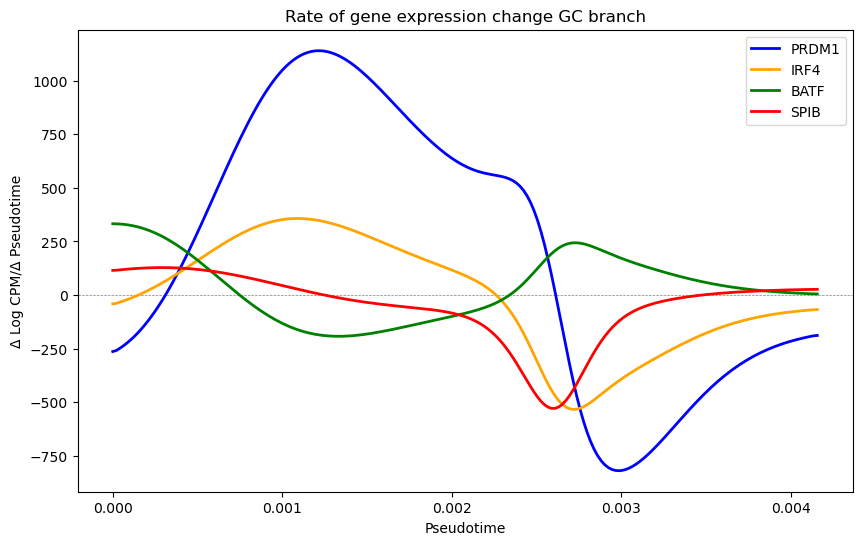

In [29]:
plt.figure(figsize=(10, 6))

# Add horizontal line at y=0 first (so it's behind the data)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot gene trajectories
genes_of_interest = ['PRDM1', 'IRF4', 'BATF', 'SPIB']
colors = ['blue', 'orange', 'green', 'red']

for gene, color in zip(genes_of_interest, colors):
    if gene in gradients_df.index:
        plt.plot(dx, gradients_df.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Δ Log CPM/Δ Pseudotime')
plt.title('Rate of gene expression change GC branch')
plt.legend()
plt.show()

In [38]:
# Call compute_chars for regulation mode
dy_tf, dx_tf = compute_chars(dictys_dynamic_object,
    start=1,          # Starting node ID
    stop=3,           # Ending node ID
    num=200,          # Number of points to interpolate
    dist=0.0005,      # Smoothing distance (equispaced sampling with this distance)
    mode='regulation' # Use log(target count) for TFs
)

# Print basic info about the returns
print("DataFrame dy (target counts):")
print(f"Shape: {dy_tf.shape}")
print(f"First few genes: {list(dy_tf.index[:5])}\n")
# Optional: display first few rows and columns of expression data
print("\nTarget counts (first 5 genes x 5 timepoints):")
print(dy_tf.iloc[:5, :5])
print("Series dx (pseudotime):")
print(f"Length: {len(dx_tf)}")
print(f"First few timepoints: {list(dx_tf[:5])}")

DataFrame dy (target counts):
Shape: (245, 200)
First few genes: ['AHR', 'ARNT', 'ASCL2', 'ATF1', 'ATF2']


Target counts (first 5 genes x 5 timepoints):
              0         1         2         3         4
AHR    9.379378  9.355351  9.339850  9.335390  9.339850
ARNT   6.727920  6.714246  6.700440  6.754888  6.754888
ASCL2  3.321928  3.459432  3.459432  3.459432  3.459432
ATF1   5.392317  5.392317  5.426265  5.459432  5.426265
ATF2   6.266787  6.228819  6.209453  6.209453  6.149747
Series dx (pseudotime):
Length: 200
First few timepoints: [0.0, 2.087924804899648e-05, 4.175849609799296e-05, 6.263774414698945e-05, 8.351699219598593e-05]


In [39]:
# Calculate gradients for all TFs
gradients_df_tf = pd.DataFrame(
    np.vstack([np.gradient(dy_tf.loc[gene].values, dx_tf.values) for gene in dy_tf.index]),
    columns=dy_tf.columns,
    index=dy_tf.index
)

# Display the shape and first few rows
print("Gradients DataFrame shape:", gradients_df_tf.shape)
print("\nFirst few genes and timepoints:")
print(gradients_df_tf.iloc[:5, :5])

Gradients DataFrame shape: (245, 200)

First few genes and timepoints:
                 0            1            2             3           4
AHR   -1150.772796  -946.594535  -478.004325 -2.910383e-11 -107.127339
ARNT   -654.953515  -658.087311   973.262648  1.303873e+03  318.421971
ASCL2  6585.654973  3292.827487     0.000000 -1.455192e-11    0.000000
ATF1      0.000000   812.944313  1607.198585  0.000000e+00 -794.254272
ATF2  -1818.449118 -1372.970304  -463.745745 -1.429799e+03 -470.055404


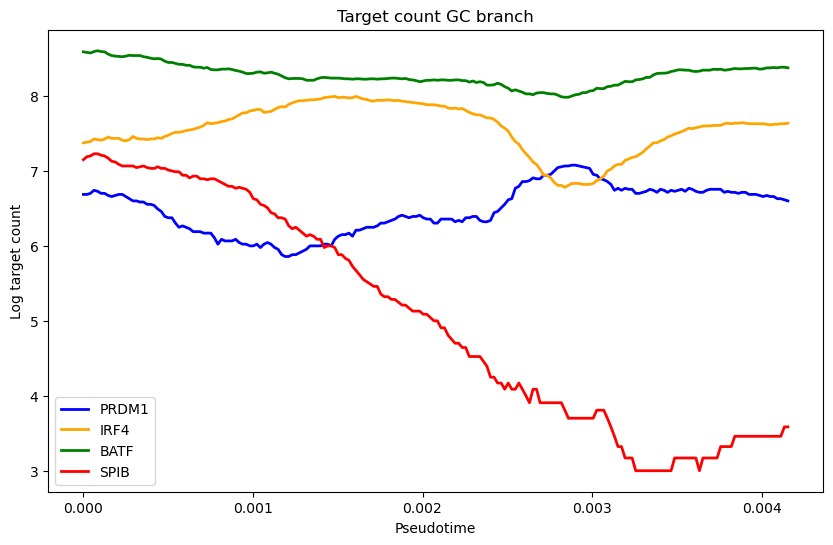

In [41]:
# Plot target count trajectories
plt.figure(figsize=(10, 6))

# Highlight specific genes
genes_of_interest = ['PRDM1', 'IRF4','BATF','SPIB']
colors = ['blue', 'orange', 'green','red','purple','gray']  # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in dy_tf.index:
        plt.plot(dx_tf, dy_tf.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Log target count')
plt.title('Target count GC branch')
plt.legend()
plt.show()

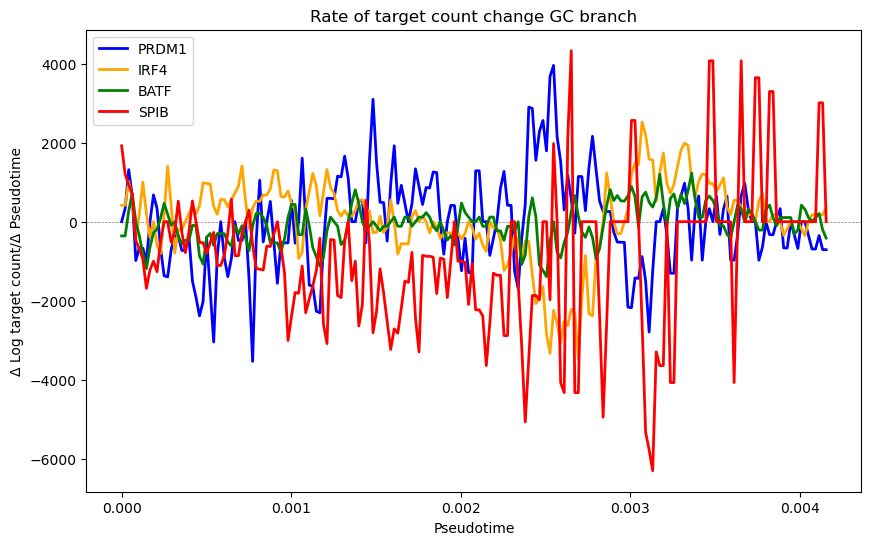

In [40]:
plt.figure(figsize=(10, 6))

# Add horizontal line at y=0 first (so it's behind the data)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot gene trajectories
genes_of_interest = ['PRDM1', 'IRF4', 'BATF', 'SPIB']
colors = ['blue', 'orange', 'green', 'red']

for gene, color in zip(genes_of_interest, colors):
    if gene in gradients_df_tf.index:
        plt.plot(dx_tf, gradients_df_tf.loc[gene], linewidth=2, label=gene, color=color)

plt.xlabel('Pseudotime')
plt.ylabel('Δ Log target count/Δ Pseudotime')
plt.title('Rate of target count change GC branch')
plt.legend()
plt.show()

# Combinatorial Control of TFs

In [46]:
# get TF pairs from combinatorial control
tf_pairs_df = pd.read_csv(tf_pairs_file)
tf_pairs_and_targets = tf_pairs_df[['TF', 'common']]
display(tf_pairs_and_targets)

,TF,common
0,"('AFF1', 'IRF4')","{'PRDM1', 'AFF3', 'ANKRD28', 'ELL2', 'HSP90B1'}"
1,"('ATF5', 'CREB3L2')","{'FNDC3B', 'SEL1L3', 'BTG2', 'SLAMF7', 'ARFGAP..."
2,"('BACH2', 'EBF1')","{'JCHAIN', 'XBP1', 'MZB1'}"
3,"('BACH2', 'FLI1')","{'JCHAIN', 'XBP1', 'MZB1'}"
4,"('BACH2', 'FOSB')","{'JCHAIN', 'XBP1', 'MZB1'}"
...,...,...
145,"('XBP1', 'IRF4')","{'TXNDC11', 'FNDC3B', 'PRDM1', 'AFF3', 'JCHAIN..."
146,"('XBP1', 'TAF3')","{'HSP90B1', 'FNDC3B', 'TXNDC5'}"
147,"('ZBTB16', 'IRF4')","{'AFF3', 'HSP90B1'}"
148,"('ZBTB16', 'XBP1')","{'JCHAIN', 'HSP90B1'}"


In [47]:
all_tfs = []
for pair_str in tf_pairs_and_targets['TF']:
    tf1, tf2 = eval(pair_str)  # Convert string representation to actual tuple
    all_tfs.extend([tf1, tf2])  # Add both TFs to the list

# Get unique TFs using set
unique_tfs = sorted(set(all_tfs))

print(f"Number of unique TFs: {len(unique_tfs)}")
print("Unique TFs:", unique_tfs)

Number of unique TFs: 75
Unique TFs: ['AFF1', 'ARID5B', 'ATF5', 'BACH2', 'BATF3', 'BCL11A', 'BCL6', 'BHLHE22', 'BHLHE41', 'CHD1', 'CREB3L2', 'EBF1', 'EGR1', 'ESR1', 'FLI1', 'FOSB', 'FOSL1', 'FOXO1', 'HBP1', 'HERPUD1', 'HIVEP1', 'HIVEP2', 'HIVEP3', 'ID2', 'IKZF1', 'IRF4', 'IRF8', 'JUN', 'JUNB', 'KLF2', 'KLF4', 'L3MBTL4', 'MEF2A', 'MEF2C', 'NFATC2', 'NFKB1', 'NR6A1', 'NRF1', 'PAX5', 'PBX3', 'PBX4', 'PHF21A', 'PLAG1', 'PLAGL1', 'POLR2A', 'POU3F1', 'PRDM1', 'PTEN', 'REL', 'RFX3', 'RREB1', 'RUNX1', 'RUNX2', 'SMAD3', 'SOX4', 'SP3', 'STAT1', 'STAT4', 'TAF1', 'TAF3', 'TCF12', 'TCF4', 'TCFL5', 'TET3', 'TFDP2', 'TFEB', 'TFEC', 'TGIF1', 'XBP1', 'ZBTB16', 'ZBTB7A', 'ZFHX3', 'ZNF318', 'ZNF506', 'ZNF652']


In [48]:
# get unique targets by opening up the {} where all targets are stored and appending to a set
unique_targets = set()
for target_set in tf_pairs_and_targets['common']:
    unique_targets.update(eval(target_set))
unique_targets = sorted(unique_targets)
print(f"Number of unique targets: {len(unique_targets)}")
print("Unique targets:", unique_targets)


Number of unique targets: 23
Unique targets: ['AFF3', 'ANKRD28', 'ARFGAP3', 'BTG2', 'CD74', 'ELL2', 'FNDC3B', 'GLCCI1', 'HSP90B1', 'IRF4', 'JCHAIN', 'MED23', 'MZB1', 'PAX5', 'PDE4D', 'PRDM1', 'RUNX2', 'SEL1L3', 'SLAMF7', 'TRAM1', 'TXNDC11', 'TXNDC5', 'XBP1']


### Filtering TF-Target pairs based on edge significance

In [49]:
def create_tf_target_pairs(dictys_dynamic_object, tf_pairs_df):
    """
    Create a list of TF-Target tuples from combinatorial control data,
    checking presence of both TFs and targets in the dynamic object.
    
    Parameters:
    -----------
    dictys_dynamic_object : dictys.net.dynamic_network
        The dynamic network object containing the regulatory network data
    tf_pairs_df : pandas.DataFrame
        DataFrame containing TF pairs and their common targets
        Columns: ['TF' (string tuple), 'common' (string set)]
        
    Returns:
    --------
    list
        List of (regulator, target) tuples where both are present in dynamic object
    """
    tf_target_pairs = []
    
    for _, row in tf_pairs_df.iterrows():
        # Get TF pair and targets
        tf1, tf2 = eval(row['TF'])
        common_targets = eval(row['common'])
        
        # Check if TFs are present in dynamic object
        present_tfs = check_tf_presence(dictys_dynamic_object, [tf1, tf2])
        
        # Check if targets are present in dynamic object
        present_targets = check_gene_presence(dictys_dynamic_object, common_targets)
        
        # Create pairs for present TFs and targets
        for tf in present_tfs:
            for target in present_targets:
                tf_target_pairs.append((tf, target))
    
    # Remove any duplicates
    tf_target_pairs = list(set(tf_target_pairs))
    
    print(f"Created {len(tf_target_pairs)} unique TF-target pairs")
    return tf_target_pairs

In [50]:
cc_tf_target_pairs = create_tf_target_pairs(dictys_dynamic_object, tf_pairs_and_targets)
display(cc_tf_target_pairs)

Created 196 unique TF-target pairs


[('FLI1', 'AFF3'),
 ('SP3', 'HSP90B1'),
 ('PRDM1', 'IRF4'),
 ('PRDM1', 'JCHAIN'),
 ('BACH2', 'PRDM1'),
 ('IKZF1', 'JCHAIN'),
 ('NFKB1', 'FNDC3B'),
 ('HBP1', 'HSP90B1'),
 ('REL', 'PRDM1'),
 ('STAT1', 'RUNX2'),
 ('ZFHX3', 'PDE4D'),
 ('TFEB', 'TXNDC5'),
 ('IRF4', 'ELL2'),
 ('JUN', 'PAX5'),
 ('NFKB1', 'IRF4'),
 ('NRF1', 'TXNDC11'),
 ('IRF4', 'HSP90B1'),
 ('NRF1', 'JCHAIN'),
 ('TGIF1', 'XBP1'),
 ('PLAG1', 'TXNDC5'),
 ('JUN', 'IRF4'),
 ('PBX3', 'AFF3'),
 ('PRDM1', 'RUNX2'),
 ('IRF8', 'TRAM1'),
 ('RREB1', 'TRAM1'),
 ('NFKB1', 'PRDM1'),
 ('TGIF1', 'SEL1L3'),
 ('FOSB', 'TRAM1'),
 ('SOX4', 'PRDM1'),
 ('BACH2', 'AFF3'),
 ('BATF3', 'MZB1'),
 ('RFX3', 'IRF4'),
 ('KLF4', 'AFF3'),
 ('REL', 'AFF3'),
 ('BATF3', 'IRF4'),
 ('XBP1', 'TXNDC5'),
 ('BACH2', 'PAX5'),
 ('BCL6', 'AFF3'),
 ('RREB1', 'TXNDC5'),
 ('TFEB', 'PAX5'),
 ('NFKB1', 'XBP1'),
 ('HBP1', 'JCHAIN'),
 ('MEF2A', 'XBP1'),
 ('IRF4', 'TXNDC11'),
 ('PRDM1', 'PAX5'),
 ('NR6A1', 'PAX5'),
 ('PLAG1', 'MZB1'),
 ('SP3', 'TXNDC5'),
 ('IRF4', 'JCHAIN'),
 (

In [51]:
# Get unique TFs and targets from the pairs
tfs = sorted(set(pair[0] for pair in cc_tf_target_pairs))
targets = sorted(set(pair[1] for pair in cc_tf_target_pairs))

# Create DataFrame with TFs as rows and targets as columns
cc_tf_target_pairs_df = pd.DataFrame(0, index=tfs, columns=targets)

# Fill in the DataFrame with 1s for existing TF-target pairs
for tf, target in cc_tf_target_pairs:
    cc_tf_target_pairs_df.loc[tf, target] = 1

display(cc_tf_target_pairs_df)

,AFF3,ANKRD28,BTG2,CD74,ELL2,FNDC3B,GLCCI1,HSP90B1,IRF4,JCHAIN,...,PAX5,PDE4D,PRDM1,RUNX2,SEL1L3,SLAMF7,TRAM1,TXNDC11,TXNDC5,XBP1
BACH2,1,0,0,0,0,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,1
BATF3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
BCL6,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
EGR1,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ESR1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
FLI1,1,0,0,0,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
FOSB,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1
FOSL1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
FOXO1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HBP1,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# now get the tf indices for the tfs in cc_tf_target_pairs
tf_indices_cc, _ = get_tf_indices(dictys_dynamic_object, tfs)
display(len(tf_indices_cc))

40

In [53]:
# get the gene indices for the targets in cc_tf_target_pairs
gene_indices_cc = get_target_gene_indices(dictys_dynamic_object, targets)
display(len(gene_indices_cc))
#display(gene_indices_cc)

22

In [54]:
# get weights across windows
weights_tf_target_pb = get_weights_for_tf_target_pairs(dictys_dynamic_object, tf_indices_cc, gene_indices_cc, pb_window_indices)
display(weights_tf_target_pb.shape)

(40, 22, 17)

#### Plot the filtered TF-target pairs

dx values:  0     0.000000
11    0.000397
22    0.000793
33    0.001190
44    0.001586
55    0.001983
66    0.002380
77    0.002776
88    0.003173
99    0.003570
dtype: float64


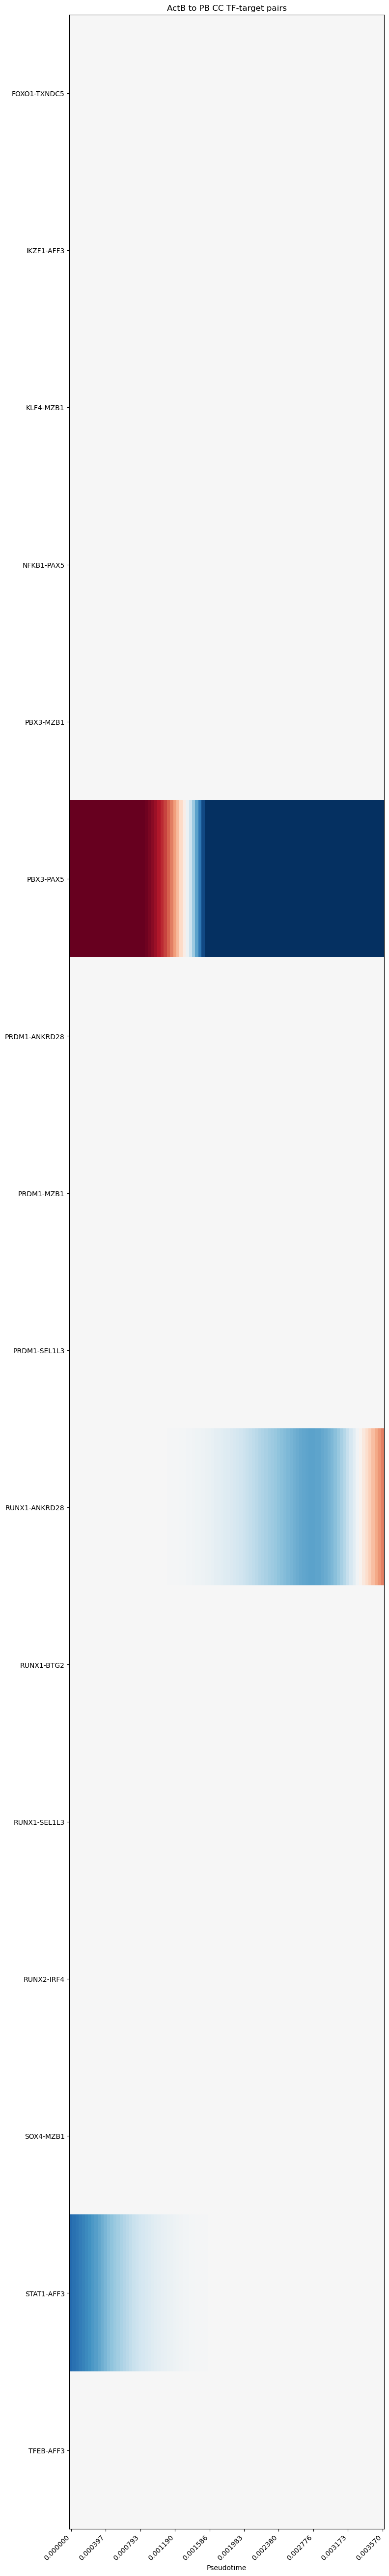

In [32]:
# Plot for PB branch (including ACtB cells)
fig_pb, ax_pb, cmap_pb = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=1,  # First window index for PB branch
    stop=2,  # Last window index for PB branch
    regulations=cc_tf_target_pairs,
    num=100,  # Number of points to interpolate
    dist=0.0005,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    figsize=(8, 4),  # Adjust figure size as needed
    cmap='RdBu'
)
plt.title('ActB to PB CC TF-target pairs')
plt.tight_layout()
plt.show()